In [387]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report

%matplotlib inline

In [65]:
survey_df = pd.concat([pd.read_csv("data/processed/ProcessedSurveyDataWithID_%d.csv" % i) for i in range(2020,2023)])

In [66]:
SURVEY_YEAR = "SurveyYear"
TITLE = "CurrentTitle"

In [67]:
survey_df.loc[survey_df["CurrentTitle"].isin(["Machine Learning/ MLops Engineer", "Machine Learning Engineer"]), "CurrentTitle"] = "Machine Learning Engineer"
survey_df.loc[survey_df["CurrentTitle"].isin(["Data Analyst", "Business Analyst", "Data Analyst (Business, Marketing, Financial, Quantitative, etc)"]), "CurrentTitle"] = "Data Analyst"

In [68]:
CLASSES = ["Research Scientist", "Data Scientist", "Data Analyst", "Machine Learning Engineer", "Data Engineer"]
CLASSES_FILTER = survey_df[TITLE].isin(CLASSES)

In [69]:
def year_filter(years=[2022]):
    return survey_df[SURVEY_YEAR].isin(years)

## Feature Engineering
- Age (Numeric?)
- Country (Categorical)
- MOOCLearning (#Platforms used - Numeric)
- UniversityCourse (bool)
- Highest Education (Cat)
- Research (Should use only 2022 data for this ?) - Figure out
- Programming Experience (Numeric)
- PythonUsed?
- SQL Used?
- R Used?
- Number of Programming Languages used (numeric)
- IDEs Used
- #HostedNBsUsed
- VizInPython
- VizInR
- #VizLibraries
- ML Exposure
- MLFrameworks
- #CV ALgos
- #NLP Algos
- TransferLearningDegree
- InvestmentInML
- AWS
- GCP
- Azure
- #CloudProviders
- ExperienceWithCloudCompute
- ExperienceWithCloudStorage
- ExperienceWithRelationalDB
- ExperienceWithNonRelationalDB
- ExperienceWithBITools
- PowerBI
- Tableau
- ExperienceWithMLaas
- ExperienceWithAutoML
- ExperienceWithMLDeploymentTools
- ExperienceWithMLMonitoringTools
- ResponsibleAI
- GPUUsed
- TPUUsageFrequecy
- ExperienceWithSpecializedhardware
- EngagementWithDSMedia
- ExperiencePipelineAutomation

#### Helper Functions

In [81]:
def get_col_names(df, include_kws, exclude_kws):
    """
    Return the column names that match any of include_kw and none of the exclude_kw
    """
    res_cols = []
    for col in df.columns:
        inc = False
        for include_kw in include_kws:
            inc = inc or (include_kw in col)
        exc = False
        for exclude_kw in exclude_kws:
            exc = exc or (exclude_kw in col)
        if inc and (not exc):
            res_cols.append(col)
    return res_cols

In [93]:
def add_col_to_df1(df1, df2, col_name, new_col_name, identifier="PID"):
    res = pd.merge(df1, df2[[identifier, col_name]], on=identifier, how="inner")
    res = res.rename({col_name: new_col_name}, axis=1)
    return res

In [95]:
def get_frequency_feature_in_df1(df1, df2, cols, new_col_name, identifier="PID"):
    df2 = df2.copy()
    df2["AggCol"] = df2[cols].sum(axis=1)
    res = add_col_to_df1(df1, df2[[identifier, "AggCol"]], "AggCol", new_col_name)
    del df2
    return res

In [97]:
adf = survey_df.loc[CLASSES_FILTER, ["PID", TITLE, "Age", "Country"]]

In [106]:
CATEGORICAL_FEATURES = ["Age"]
BINARY_FEATURES = []
NUMERICAL_FEATURES = []

<center> Feature: <b>Country (Leveraging Country Clustering from <a href="https://www.kaggle.com/code/michau96/15-factors-for-data-science-in-your-country"> Kaggle Notebook </a> )</b> </center>

In [60]:
country_cluster_mapping = {
    "AsianFuture": ['Russia', 'Egypt', 'Viet Nam', 'India', 'China', 'Nigeria', 'Pakistan', 'Indonesia', 'Bangladesh', 'Morocco', 'Iran, Islamic Republic of...', 'Tunisia'],
    "DevelopedGuards" : ['Portugal', 'Israel', 'United Kingdom of Great Britain and Northern Ireland', 'Italy', 'Spain', 'Canada', 'Australia', 'United States of America', 'Poland', 'France', 'Germany', 'Netherlands', 'United Arab Emirates', 'Japan'],
    "SouthAmericaAndOthers": ['Peru', 'Colombia', 'South Africa', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Turkey', 'Thailand', 'Taiwan', 'South Korea', 'Saudi Arabia', 'Philippines']
}

In [61]:
def get_country_cluster(country):
    for key in country_cluster_mapping.keys():
        if country in country_cluster_mapping[key]:
            return key
    return "Others"

In [52]:
get_country_cluster("Peru")

'SouthAmericaAndOthers'

In [98]:
adf["CountryClusters"] = adf["Country"].apply(lambda x:get_country_cluster(x))

In [105]:
CATEGORICAL_FEATURES.append("CountryClusters")

<center> Feature: <b>MOOC Learning Platforms</b> </center>

In [99]:
adf = add_col_to_df1(adf, survey_df, "MOOCPlatforms_University Courses (resulting in a university degree)", "CompletedUniDegree")

In [102]:
MOOC_COLS = get_col_names(survey_df, include_kws=["MOOCPlatforms_"], exclude_kws=["Other", "None"])

In [103]:
adf = get_frequency_feature_in_df1(adf, survey_df, MOOC_COLS, "NumCoursePlatforms")

In [107]:
BINARY_FEATURES.append("CompletedUniDegree")
NUMERICAL_FEATURES.append("NumCoursePlatforms")

<center> Feature: <b>Highest Education (Ordinal - Treated as numeric)</b> </center>

In [109]:
adf = add_col_to_df1(adf, survey_df, "HighestEducation", "HighestEducation")

In [145]:
enc = OrdinalEncoder(categories=[["Other", "Lower than Bachelor", "Bachelor", "Master", "Higher than Master"]])
adf["EduOrdinal"] = enc.fit_transform(adf["HighestEducation"].to_numpy().reshape(-1,1))

In [164]:
NUMERICAL_FEATURES.append("EduOrdinal")

<center> Feature: <b>Programming Experience (Ordinal - Treated as Numeric)</b> </center>

In [158]:
adf = add_col_to_df1(adf, survey_df, "Programming Experience", "Programming Experience")

In [160]:
adf["Programming Experience"] = adf["Programming Experience"].fillna('I have never written code')

In [162]:
enc = OrdinalEncoder(categories=[['I have never written code', '< 1 years', '1-2 years', '1-3 years', '3-5 years', '5-10 years', '10-20 years', '20+ years']])
adf["ProgExpOrdinal"] = enc.fit_transform(adf["Programming Experience"].to_numpy().reshape(-1,1))

In [165]:
NUMERICAL_FEATURES.append("ProgExpOrdinal")

<center> Feature: <b>Programming Languages</b> </center>

In [167]:
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_Python", "UsedPython")
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_R", "UsedR")
adf = add_col_to_df1(adf, survey_df, "ProgLanguage_SQL", "UsedSQL")

In [169]:
BINARY_FEATURES.extend(["UsedPython", "UsedR", "UsedSQL"])

In [173]:
PROGLANG_COLS = get_col_names(survey_df, include_kws=["ProgLanguage_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, PROGLANG_COLS, "NumProgLanguages")

In [175]:
NUMERICAL_FEATURES.append("NumProgLanguages")

<center> Feature: <b>IDEs</b> </center>

In [ ]:
survey_df["JupyterUsage"] = survey_df[get_col_names(survey_df, include_kws=["IDE_Jupyter"], exclude_kws=["Other", "None"])].fillna(0).sum(axis=1)
survey_df.loc[survey_df["JupyterUsage"]==2, "JupyterUsage"] = 1

In [189]:
adf = add_col_to_df1(adf, survey_df, "JupyterUsage", "UsedJupyter")

In [191]:
BINARY_FEATURES.extend(["UsedJupyter"])

In [192]:
IDE_COLS = get_col_names(survey_df, include_kws=["IDE_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, IDE_COLS, "NumIDEsUsed")

<center> Feature: <b>Visualization Experience</b> </center>

In [202]:
PYTHON_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_Altair", "VizLib_Bokeh", "VizLib_Geoplotlib", "VizLib_Matplotlib", "VizLib_Plotly", "VizLib_Seaborn", "VizLib_Pygal"], exclude_kws=["Other", "None"])
JS_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_D3 js"], exclude_kws=["Other", "None"])
R_VIZ_COLNAMES = get_col_names(survey_df, include_kws=["VizLib_Dygraphs", "VizLib_Ggplot", "VizLib_Highchart", "VizLib_Shiny"], exclude_kws=["Other", "None"])

In [207]:
survey_df["PyVizUsage"] = survey_df[PYTHON_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["PyVizUsage"]>1, "PyVizUsage"] = 1

survey_df["RVizUsage"] = survey_df[R_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["RVizUsage"]>1, "RVizUsage"] = 1

survey_df["JSVizUsage"] = survey_df[JS_VIZ_COLNAMES].fillna(0).sum(axis=1)
survey_df.loc[survey_df["JSVizUsage"]>1, "JSVizUsage"] = 1

In [210]:
adf = add_col_to_df1(adf, survey_df, "PyVizUsage", "UsedPyViz")
adf = add_col_to_df1(adf, survey_df, "RVizUsage", "UsedRViz")
adf = add_col_to_df1(adf, survey_df, "JSVizUsage", "UsedJSViz")

In [212]:
BINARY_FEATURES.extend(["UsedPyViz", "UsedRViz", "UsedJSViz"])

<center> Feature: <b>ML Exposure</b> </center>

In [226]:
adf["MLExposure"].unique()

array(['1-2 years', '3-4 years', 'I do not use machine learning methods',
       '2-3 years', 'Under 1 year', '4-5 years', '5-10 years',
       '20 or more years', '10-20 years'], dtype=object)

In [227]:
adf = add_col_to_df1(adf, survey_df, "MLExposure", "MLExposure")
adf["MLExposure"] = adf["MLExposure"].fillna('I do not use machine learning methods')

enc = OrdinalEncoder(categories=[['I do not use machine learning methods', 'Under 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years', '20 or more years']])
adf["MLExpOrdinal"] = enc.fit_transform(adf["MLExposure"].to_numpy().reshape(-1,1))

In [229]:
NUMERICAL_FEATURES.append("MLExpOrdinal")

<center> Feature: <b>ML Frameworks</b> </center>

In [232]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Scikit-learn", "UsedSKlearn")

In [233]:
survey_df["TFKerasUsage"] = survey_df[['MLFramework_TensorFlow','MLFramework_Keras']].fillna(0).sum(axis=1)
survey_df.loc[survey_df["TFKerasUsage"]>1, "TFKerasUsage"] = 1
adf = add_col_to_df1(adf, survey_df, "TFKerasUsage", "UsedTFKeras")

In [235]:
survey_df["PyTorchUsage"] = survey_df[['MLFramework_PyTorch','MLFramework_PyTorch Lightning']].fillna(0).sum(axis=1)
survey_df.loc[survey_df["PyTorchUsage"]>1, "PyTorchUsage"] = 1
adf = add_col_to_df1(adf, survey_df, "PyTorchUsage", "UsedPyTorch")

In [236]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Huggingface", "UsedHF")

In [237]:
adf = add_col_to_df1(adf, survey_df, "MLFramework_Fast.ai", "UsedFastAI")

In [238]:
BINARY_FEATURES.extend(["UsedSKlearn", "UsedTFKeras", "UsedPyTorch", "UsedHF", "UsedFastAI"])

In [239]:
MLFRAMEWORK_COLS = get_col_names(survey_df, include_kws=["MLFramework_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, MLFRAMEWORK_COLS, "NumMLFrameworks")

In [240]:
NUMERICAL_FEATURES.append("NumMLFrameworks")

<center> Feature: <b>ML Algorithms</b> </center>

In [241]:
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Linear or Logistic Regression", "UsedLinearModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Decision Trees or Random Forests", "UsedTreeModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Gradient Boosting Machines (xgboost, lightgbm, etc)", "UsedGBModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Bayesian Approaches", "UsedBayesianModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Evolutionary Approaches", "UsedEvolutionaryModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Dense Neural Networks (MLPs, etc)", "UsedNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Convolutional Neural Networks", "UsedCNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Generative Adversarial Networks", "UsedGANModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Transformer Networks (BERT, gpt-3, etc)", "UsedTransformerModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Autoencoder Networks (DAE, VAE, etc)", "UsedAEModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Recurrent Neural Networks", "UsedRNNModels")
adf = add_col_to_df1(adf, survey_df, "MLAlgo_Graph Neural Networks", "UsedGraphModels")

In [242]:
BINARY_FEATURES.extend(["UsedLinearModels","UsedTreeModels","UsedGBModels","UsedBayesianModels","UsedEvolutionaryModels","UsedNNModels","UsedCNNModels","UsedGANModels","UsedTransformerModels","UsedAEModels","UsedRNNModels","UsedGraphModels"])

<center> Feature: <b>Transfer Learning</b> </center>

In [244]:
PRETRAINED_COLS = get_col_names(survey_df, include_kws=["DownloadPreTrainedWeights_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, PRETRAINED_COLS, "NumTransferLearning")

In [245]:
NUMERICAL_FEATURES.append("NumTransferLearning")

<center> Feature: <b>CloudProviders</b> </center>

In [249]:
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Google Cloud Platform (GCP)", "UsedGCP")
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Amazon Web Services (AWS)", "UsedAWS")
adf = add_col_to_df1(adf, survey_df, "CloudProviderUsed_Microsoft Azure", "UsedAzure")

In [250]:
BINARY_FEATURES.extend(["UsedGCP", "UsedAWS", "UsedAzure"])

In [251]:
CLOUDPROVIDER_COLS = get_col_names(survey_df, include_kws=["CloudProviderUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDPROVIDER_COLS, "NumCloudProvidersUsed")

In [252]:
NUMERICAL_FEATURES.append("NumCloudProvidersUsed")

<center> Feature: <b>CloudCompute</b> </center>

In [253]:
CLOUDCOMPUTE_COLS = get_col_names(survey_df, include_kws=["CloudComputeUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDCOMPUTE_COLS, "NumCloudComputeUsed")
NUMERICAL_FEATURES.append("NumCloudComputeUsed")

<center> Feature: <b>CloudStorage</b> </center>

In [254]:
CLOUDSTORAGE_COLS = get_col_names(survey_df, include_kws=["CloudStorageUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, CLOUDSTORAGE_COLS, "NumCloudStorageUsed")
NUMERICAL_FEATURES.append("NumCloudStorageUsed")

<center> Feature: <b>DBUSed</b> </center>

In [255]:
get_col_names(survey_df, include_kws=["DBUsed_"], exclude_kws=["Other", "None"])

['DBUsed_MySQL',
 'DBUsed_PostgreSQL',
 'DBUsed_SQLite',
 'DBUsed_Oracle Database',
 'DBUsed_MongoDB',
 'DBUsed_Snowflake',
 'DBUsed_IBM Db2',
 'DBUsed_Microsoft SQL Server',
 'DBUsed_Microsoft Azure SQL Database',
 'DBUsed_Amazon Redshift',
 'DBUsed_Amazon RDS',
 'DBUsed_Amazon DynamoDB',
 'DBUsed_Google Cloud BigQuery',
 'DBUsed_Google Cloud SQL',
 'DBUsed_Microsoft Azure Cosmos DB',
 'DBUsed_Amazon Aurora',
 'DBUsed_Google Cloud Firestore',
 'DBUsed_Google Cloud BigTable',
 'DBUsed_Google Cloud Spanner',
 'DBUsed_PostgresSQL',
 'DBUsed_Microsoft Access',
 'DBUsed_Microsoft Azure Data Lake Storage',
 'DBUsed_Amazon Athena']

In [256]:
rel_db_map = {
    "Relational": ,
    "Non-relational": 
}

In [257]:
def get_db_type(db):
    for key in rel_db_map.keys():
        if db in rel_db_map[key]:
            return key
    return "Others"

In [261]:
RELATIONAL_DBS = ["DBUsed_Microsoft Access","DBUsed_Google Cloud Spanner","DBUsed_Amazon Aurora","DBUsed_Microsoft Azure Cosmos DB","DBUsed_Google Cloud SQL","DBUsed_Google Cloud BigQuery","DBUsed_Amazon RDS","DBUsed_Amazon Redshift","DBUsed_Snowflake", "DBUsed_IBM Db2", "DBUsed_Microsoft SQL Server", "DBUsed_Microsoft Azure SQL Database","DBUsed_MySQL", "DBUsed_PostgreSQL", "DBUsed_PostgresSQL", "DBUsed_SQLite", 'DBUsed_Oracle Database']
NON_RELATIONAL_DBS = ["DBUsed_Google Cloud BigTable","DBUsed_Google Cloud Firestore","DBUsed_Microsoft Azure Cosmos DB","DBUsed_Amazon DynamoDB","DBUsed_MongoDB"]

In [270]:
survey_df["UsedRelationalDBs"] = survey_df[RELATIONAL_DBS].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)
survey_df["UsedNonRelationalDBs"] = survey_df[NON_RELATIONAL_DBS].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [271]:
adf = add_col_to_df1(adf, survey_df, "UsedRelationalDBs", "UsedRelationalDBs")
adf = add_col_to_df1(adf, survey_df, "UsedNonRelationalDBs", "UsedNonRelationalDBs")

In [272]:
BINARY_FEATURES.extend(["UsedRelationalDBs","UsedNonRelationalDBs"])

<center> Feature: <b>BI Tools</b> </center>

In [273]:
survey_df["UsedTableau"] = survey_df[["BIToolUsed_Tableau", "BIToolUsed_Tableau CRM"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [274]:
adf = add_col_to_df1(adf, survey_df, "BIToolUsed_Microsoft Power BI", "UsedPowerBI")
adf = add_col_to_df1(adf, survey_df, "UsedTableau", "UsedTableau")

In [275]:
BINARY_FEATURES.extend(["UsedPowerBI","UsedTableau"])

In [276]:
BI_COLS = get_col_names(survey_df, include_kws=["BIToolUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, BI_COLS, "NumBIToolsUsed")

In [277]:
NUMERICAL_FEATURES.append("NumBIToolsUsed")

<center> Features: <b>MLaaS, AutoML, Deployment, Monitoring Tools</b> </center>

In [ ]:
survey_df["MLMonitoringToolUsed_"]

In [279]:
COLS = get_col_names(survey_df, include_kws=["MLaaS_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLaaSToolsUsed")
NUMERICAL_FEATURES.append("NumMLaaSToolsUsed")

In [296]:
COLS = get_col_names(survey_df, include_kws=["AutoMLUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumAutoMLUsed")
NUMERICAL_FEATURES.append("NumAutoMLUsed")

In [281]:
COLS = get_col_names(survey_df, include_kws=["MLDeploymentToolsUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLDeploymentToolsUsed")
NUMERICAL_FEATURES.append("NumMLDeploymentToolsUsed")

In [282]:
COLS = get_col_names(survey_df, include_kws=["MLMonitoringToolUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumMLMonitoringToolUsed")
NUMERICAL_FEATURES.append("NumMLMonitoringToolUsed")

<center> Feature: <b>Hardware</b> </center>

In [285]:
survey_df["DSContentMediaConsumed_"].unique()

array(['2-5 times', 'Never', nan, '6-25 times', 'Once',
       'More than 25 times'], dtype=object)

In [283]:
survey_df["UsedGPU"] = survey_df[["HardwareUsed_GPUs", "HardwareUsed_NVIDIA GPUs"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [286]:
adf = add_col_to_df1(adf, survey_df, "UsedGPU", "UsedGPU")

In [287]:
BINARY_FEATURES.extend(["UsedGPU"])

In [288]:
adf = add_col_to_df1(adf, survey_df, "TPUUsageFrequency", "TPUUsageFrequency")

In [289]:
adf["TPUUsageFrequency"] = adf["TPUUsageFrequency"].fillna('Never')

enc = OrdinalEncoder(categories=[['Never', 'Once', '2-5 times', '6-25 times', 'More than 25 times']])
adf["TPUUsageOrdinal"] = enc.fit_transform(adf["TPUUsageFrequency"].to_numpy().reshape(-1,1))

In [290]:
COLS = get_col_names(survey_df, include_kws=["HardwareUsed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumHardwareUsed")
NUMERICAL_FEATURES.append("NumHardwareUsed")

In [291]:
NUMERICAL_FEATURES.append("TPUUsageOrdinal")

<center> Feature: <b>DSMedia</b> </center>

In [292]:
COLS = get_col_names(survey_df, include_kws=["DSContentMediaConsumed_"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumDSContentMediaConsumed")
NUMERICAL_FEATURES.append("NumDSContentMediaConsumed")

<center> Feature: <b>PipelineAutomation</b> </center>

In [303]:
survey_df["UsedE2EPipelineAutomation"] = survey_df[["AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H2O Driverless AI)", "AutoMLFrameworksUsed_Automation of full ML pipelines (e.g. Google AutoML, H20 Driverless AI)"]].fillna(0).sum(axis=1).apply(lambda x:1 if x>=1 else 0)

In [297]:
COLS = get_col_names(survey_df, include_kws=["AutoMLFrameworksUsed_Automated"], exclude_kws=["Other", "None"])
adf = get_frequency_feature_in_df1(adf, survey_df, COLS, "NumStepsOfPipelineAutomated")
NUMERICAL_FEATURES.append("NumStepsOfPipelineAutomated")

In [304]:
adf = add_col_to_df1(adf, survey_df, "UsedE2EPipelineAutomation", "UsedE2EPipelineAutomation")
BINARY_FEATURES.extend(["UsedE2EPipelineAutomation"])

In [403]:
adf[["PID",TITLE]+CATEGORICAL_FEATURES+NUMERICAL_FEATURES+BINARY_FEATURES].fillna(0).to_csv("data/processed/DS-MLE-DA-DE-RS-FeatureEngineered.csv", index=False)

<center> Modeling: <b>Classification of Title</b> </center>

In [313]:
class_df = adf[["PID",TITLE]+CATEGORICAL_FEATURES+NUMERICAL_FEATURES+BINARY_FEATURES].fillna(0)

In [316]:
mms = MinMaxScaler()
class_df[NUMERICAL_FEATURES] = mms.fit_transform(class_df[NUMERICAL_FEATURES])

In [319]:
from lazypredict.Supervised import LazyClassifier

In [324]:
X = class_df[NUMERICAL_FEATURES+BINARY_FEATURES]
le = LabelEncoder()
y = le.fit_transform(class_df[TITLE])

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=42)

In [329]:
clf = LazyClassifier(verbose=1,ignore_warnings=True, custom_metric=None)

In [330]:
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

  3%|█▌                                          | 1/29 [00:00<00:18,  1.51it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.5380142149472323, 'Balanced Accuracy': 0.427983131397097, 'ROC AUC': None, 'F1 Score': 0.5167112522844037, 'Time taken': 0.6641478538513184}


 10%|████▌                                       | 3/29 [00:01<00:13,  2.00it/s]

{'Model': 'BaggingClassifier', 'Accuracy': 0.5007538229592936, 'Balanced Accuracy': 0.39432633552693724, 'ROC AUC': None, 'F1 Score': 0.4837663912161961, 'Time taken': 0.8707270622253418}
{'Model': 'BernoulliNB', 'Accuracy': 0.4807236700409218, 'Balanced Accuracy': 0.3810632061945528, 'ROC AUC': None, 'F1 Score': 0.4636374561859983, 'Time taken': 0.16102004051208496}


 21%|█████████                                   | 6/29 [00:49<03:27,  9.03s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.5399526168425587, 'Balanced Accuracy': 0.4098305882468053, 'ROC AUC': None, 'F1 Score': 0.5119459699107666, 'Time taken': 47.664560079574585}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.4148180055998277, 'Balanced Accuracy': 0.34373435447711886, 'ROC AUC': None, 'F1 Score': 0.41339294356581546, 'Time taken': 0.13826203346252441}
{'Model': 'DummyClassifier', 'Accuracy': 0.35580443678656043, 'Balanced Accuracy': 0.2, 'ROC AUC': None, 'F1 Score': 0.18674787277883967, 'Time taken': 0.022703886032104492}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.39134180486754255, 'Balanced Accuracy': 0.31593144641020865, 'ROC AUC': None, 'F1 Score': 0.3895558242683771, 'Time taken': 0.047496795654296875}


 31%|█████████████▋                              | 9/29 [00:51<01:31,  4.58s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.5257376696101659, 'Balanced Accuracy': 0.3949210586669437, 'ROC AUC': None, 'F1 Score': 0.500123661242493, 'Time taken': 1.9420506954193115}
{'Model': 'GaussianNB', 'Accuracy': 0.42881757484385097, 'Balanced Accuracy': 0.3537650894411007, 'ROC AUC': None, 'F1 Score': 0.39953849122259755, 'Time taken': 0.04147696495056152}


 38%|████████████████▎                          | 11/29 [00:51<00:55,  3.09s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.46866250269222487, 'Balanced Accuracy': 0.347053703306868, 'ROC AUC': None, 'F1 Score': 0.4440451113222254, 'Time taken': 0.21434807777404785}


 41%|█████████████████▊                         | 12/29 [00:56<00:58,  3.41s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.3713116519491708, 'Balanced Accuracy': 0.2910945790627758, 'ROC AUC': None, 'F1 Score': 0.3581685596225438, 'Time taken': 4.778311014175415}


 48%|████████████████████▊                      | 14/29 [01:05<00:52,  3.52s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.3708808959724316, 'Balanced Accuracy': 0.2912945383743951, 'ROC AUC': None, 'F1 Score': 0.35770200940354036, 'Time taken': 8.743829011917114}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.5433986646564721, 'Balanced Accuracy': 0.4302822029280433, 'ROC AUC': None, 'F1 Score': 0.5244529368660686, 'Time taken': 0.14191484451293945}


 52%|██████████████████████▏                    | 15/29 [01:18<01:22,  5.90s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.5388757269007107, 'Balanced Accuracy': 0.4015383041571988, 'ROC AUC': None, 'F1 Score': 0.5050356859297415, 'Time taken': 12.957021951675415}


 66%|████████████████████████████▏              | 19/29 [01:27<00:31,  3.18s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.5453370665517984, 'Balanced Accuracy': 0.4253631387706303, 'ROC AUC': None, 'F1 Score': 0.5229009376988415, 'Time taken': 8.9896399974823}
{'Model': 'NearestCentroid', 'Accuracy': 0.4583243592504846, 'Balanced Accuracy': 0.41635222996729093, 'ROC AUC': None, 'F1 Score': 0.4565022448676374, 'Time taken': 0.026718854904174805}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.39694163256515186, 'Balanced Accuracy': 0.3233640611685892, 'ROC AUC': None, 'F1 Score': 0.4008305909043928, 'Time taken': 0.14945602416992188}
{'Model': 'Perceptron', 'Accuracy': 0.4400172302390696, 'Balanced Accuracy': 0.32812688240686827, 'ROC AUC': None, 'F1 Score': 0.4197580260185718, 'Time taken': 0.07708501815795898}


 72%|███████████████████████████████▏           | 21/29 [01:27<00:17,  2.16s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.4393710962739608, 'Balanced Accuracy': 0.36063667151623546, 'ROC AUC': None, 'F1 Score': 0.4125192569740758, 'Time taken': 0.22583603858947754}


 83%|███████████████████████████████████▌       | 24/29 [01:29<00:06,  1.35s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.5405987508076675, 'Balanced Accuracy': 0.41238707694804005, 'ROC AUC': None, 'F1 Score': 0.5150044763961054, 'Time taken': 1.5602293014526367}
{'Model': 'RidgeClassifier', 'Accuracy': 0.5375834589704932, 'Balanced Accuracy': 0.3912989431295504, 'ROC AUC': None, 'F1 Score': 0.4994451648058605, 'Time taken': 0.03903508186340332}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.5371527029937541, 'Balanced Accuracy': 0.39088070093403965, 'ROC AUC': None, 'F1 Score': 0.49899610411759665, 'Time taken': 0.13073992729187012}


 86%|█████████████████████████████████████      | 25/29 [01:30<00:04,  1.22s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.511522722377773, 'Balanced Accuracy': 0.39026085575457187, 'ROC AUC': None, 'F1 Score': 0.48504415822499364, 'Time taken': 0.6940751075744629}


 90%|██████████████████████████████████████▌    | 26/29 [01:52<00:18,  6.03s/it]

{'Model': 'SVC', 'Accuracy': 0.5496446263191902, 'Balanced Accuracy': 0.41374243394951665, 'ROC AUC': None, 'F1 Score': 0.5185906929385723, 'Time taken': 22.629711151123047}


 97%|█████████████████████████████████████████▌ | 28/29 [01:57<00:04,  4.53s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.5408141287960371, 'Balanced Accuracy': 0.432451931791039, 'ROC AUC': None, 'F1 Score': 0.5235374066251406, 'Time taken': 4.3743181228637695}


100%|███████████████████████████████████████████| 29/29 [01:59<00:00,  4.11s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.5533060521214732, 'Balanced Accuracy': 0.4400740971560172, 'ROC AUC': None, 'F1 Score': 0.5332856098213521, 'Time taken': 1.804772138595581}


In [332]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.55,0.44,None,0.53,1.80
XGBClassifier,0.54,0.43,None,0.52,4.37
LinearDiscriminantAnalysis,0.54,0.43,None,0.52,0.14
AdaBoostClassifier,0.54,0.43,None,0.52,0.66
LogisticRegression,0.55,0.43,None,0.52,8.99
NearestCentroid,0.46,0.42,None,0.46,0.03
SVC,0.55,0.41,None,0.52,22.63
RandomForestClassifier,0.54,0.41,None,0.52,1.56
CalibratedClassifierCV,0.54,0.41,None,0.51,47.66


In [333]:
from lightgbm import LGBMClassifier

In [337]:
lightgbm = LGBMClassifier(random_state=42)
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [200, 400, 600, 800]
max_depth = [int(x) for x in np.linspace(1, 6, num = 6)]
subsample = [0.5, 0.75, 1.0]
colsample_bytree = [0.5, 0.75, 1.0]
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree)
clf = RandomizedSearchCV(estimator=lightgbm, param_distributions=grid, n_iter=200, scoring='accuracy', cv=3, n_jobs=1, verbose=True)
best_model = clf.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [338]:
print("Hello")

Hello


In [339]:
best_model.score(X_test, y_test)

0.624596166271807

In [355]:
best_model.best_params_

{'subsample': 0.75,
 'n_estimators': 800,
 'max_depth': 6,
 'learning_rate': 0.01,
 'colsample_bytree': 0.5}

In [362]:
feat_imp = sorted(list(zip(X.columns, best_model.best_estimator_.feature_importances_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

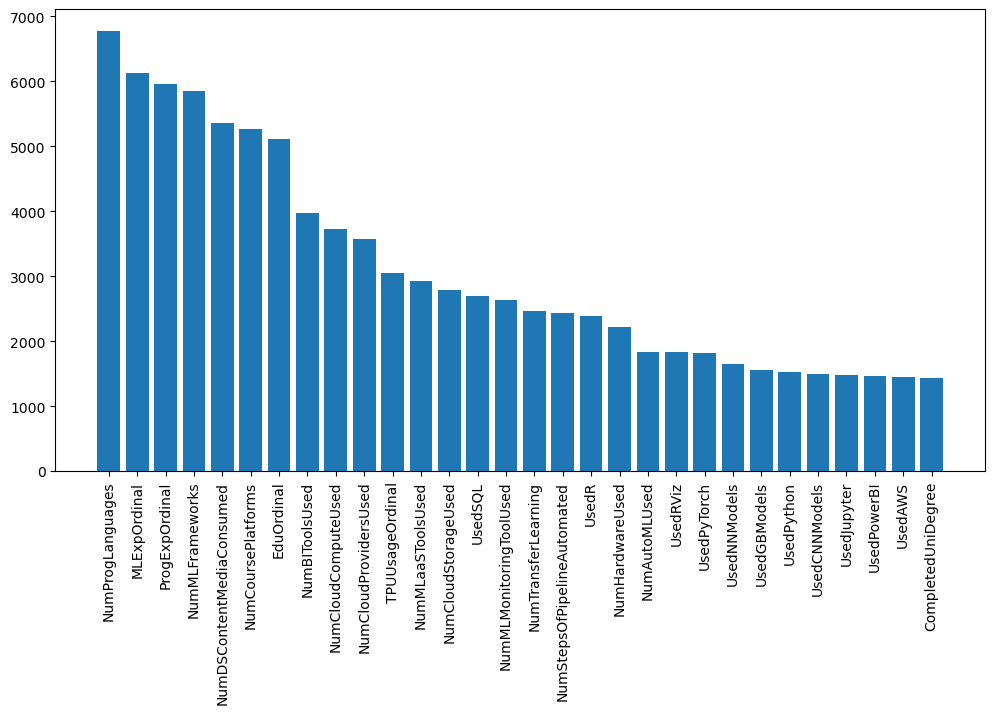

In [354]:
plt.figure(figsize=(12,6))
plt.bar(feat_name[:30], feat_imp_score[:30])
plt.xticks(rotation=90);


In [356]:
lightgbm1 = LGBMClassifier(**best_model.best_params_, random_state=42)

In [381]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state=42)

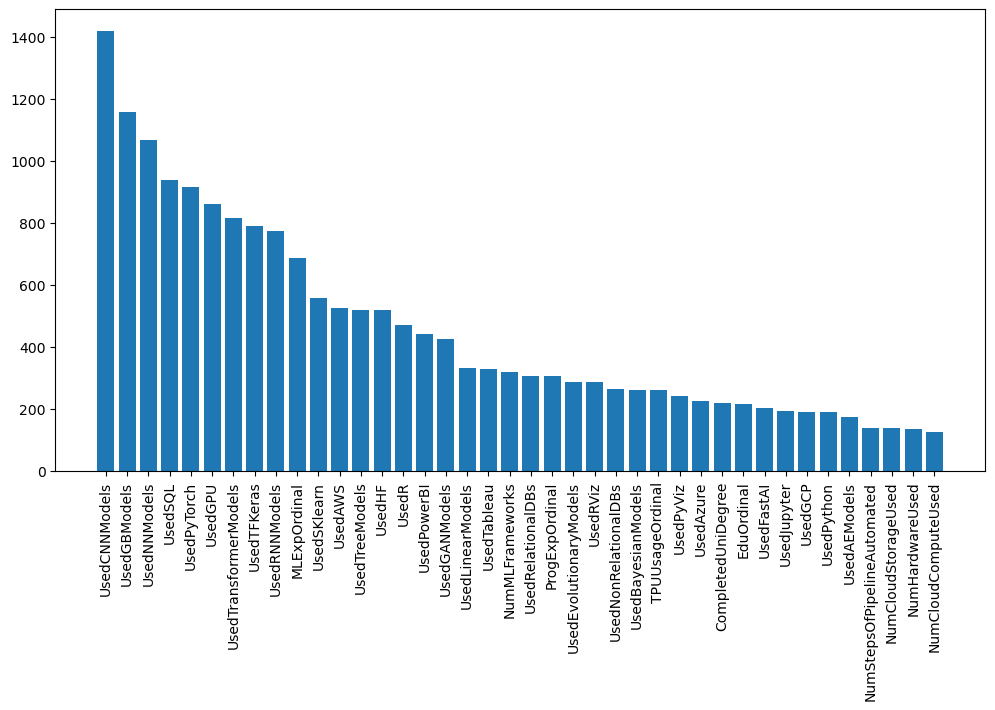

In [369]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, y)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X_train.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);


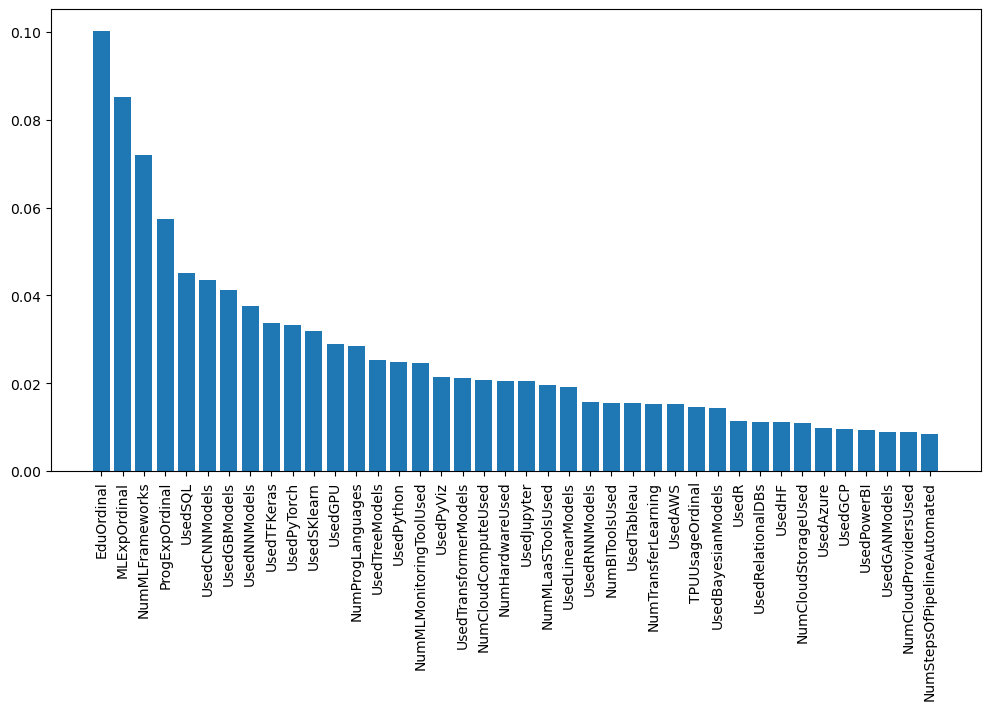

In [382]:
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(X, y)
# for i in range(len(fs.scores_)):
# 	print('Feature %s: %f' % (X_train.columns[i], fs.scores_[i]))

feat_imp = sorted(list(zip(X_train.columns, fs.scores_)), key=lambda x:x[1], reverse=True)
feat_name = list(map(lambda x:x[0], feat_imp))
feat_imp_score = list(map(lambda x:x[1], feat_imp))

plt.figure(figsize=(12,6))
plt.bar(feat_name[:40], feat_imp_score[:40])
plt.xticks(rotation=90);


In [383]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

In [384]:
lightgbm1 = LGBMClassifier(**best_model.best_params_, random_state=42)
lightgbm1.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=6,
               n_estimators=800, random_state=42, subsample=0.75)

In [386]:
lightgbm1.score(X_train, y_train)

0.6061275037691148

In [389]:
print(classification_report(y_test, lightgbm1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.72      0.63      1393
           1       0.39      0.06      0.10       275
           2       0.54      0.62      0.58      1652
           3       0.44      0.24      0.31       650
           4       0.60      0.54      0.57       673

    accuracy                           0.55      4643
   macro avg       0.51      0.44      0.44      4643
weighted avg       0.54      0.55      0.53      4643



In [390]:
le.inverse_transform([0,1,2,3,4])

array(['Data Analyst', 'Data Engineer', 'Data Scientist',
       'Machine Learning Engineer', 'Research Scientist'], dtype=object)

In [406]:
class_df.groupby(TITLE).agg(c=(TITLE, "count"))

,c
CurrentTitle,
Data Analyst,7080
Data Engineer,1457
Data Scientist,8221
Machine Learning Engineer,3152
Research Scientist,3305


In [404]:
n=2
y_pred = lightgbm1.predict(X_test)
y_pred_proba = lightgbm1.predict_proba(X_test)
topn = np.argsort(y_pred_proba, axis = 1)[:,-n:]
np.mean(np.array([1 if y_test[k] in topn[k] else 0 for k in range(len(topn))]))

0.7932371311651949

In [401]:
y_pred_proba

array([[0.04723798, 0.03512166, 0.11996674, 0.65200913, 0.14566449],
       [0.01807343, 0.00745303, 0.14440442, 0.10775271, 0.7223164 ],
       [0.53535767, 0.12195788, 0.26746301, 0.0421472 , 0.03307424],
       ...,
       [0.35223381, 0.04118676, 0.33190536, 0.22730547, 0.04736861],
       [0.66087302, 0.08067026, 0.22251797, 0.01137913, 0.02455962],
       [0.49996679, 0.11443199, 0.35208673, 0.02773789, 0.0057766 ]])